In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
from codes import utils, hf, kwant_examples
from tqdm import tqdm

In [2]:
def hamiltonian(k):
    tk = (1 + np.exp(1j * k)) * np.eye(2)
    return np.block([
        [0 * np.eye(2), tk],
        [tk.conj(), 0 * np.eye(2)]
    ])

In [3]:
# Compute non-interacting Hamiltonian on a coarse k-point grid
# Number of k-points along each direction
nk = 50
# k-points must start at zero
ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)
hamiltonians_0 = np.array([hamiltonian(k) for k in ks])
hopping_vecs = np.array([[0,], [1,], [-1,]])

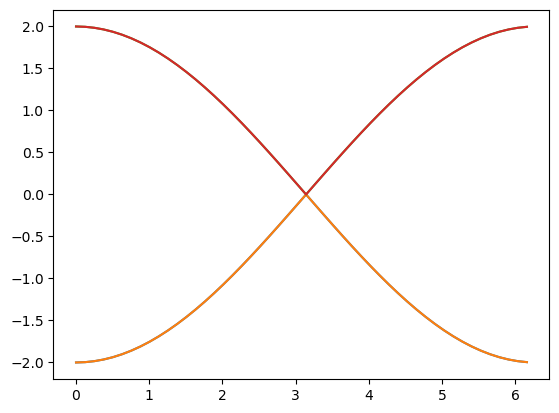

In [4]:
vals, vecs = np.linalg.eigh(hamiltonians_0)
plt.plot(ks, vals)
plt.show()

In [8]:
def compute_gap(
    H_int,
    ks,
    ks_dense,
    hamiltonians_0=hamiltonians_0,
    filling=2,
    tol=1e-5,
    mixing=0.01,
    order=10,
    guess=None
):
    # Generate guess on the same grid
    if guess is None:
        guess = utils.generate_guess(ks, hopping_vecs, ndof=hamiltonians_0.shape[-1], scale=1)
    else:
        guess += np.max(guess) * utils.generate_guess(ks, hopping_vecs, ndof=hamiltonians_0.shape[-1], scale=0.1)

    # Find groundstate Hamiltonian on the same grid
    hk = hf.find_groundstate_ham(
        H_int=H_int,
        filling=filling,
        hamiltonians_0=hamiltonians_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(hk)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, filling)
    gap = utils.calc_gap(vals, E_F)
    return gap, hk - hamiltonians_0, vals - E_F

In [23]:
def compute_phase_diagram(
    Us,
    ks,
    ks_dense,
    tol=1e-5,
    mixing=0.01,
    order=10,
):
    # onsite interactions
    v_int = np.block(
        [[np.ones((2, 2)), np.zeros((2, 2))], [np.zeros((2, 2)), np.ones((2, 2))]]
    )
    v_int = np.array([v_int for k in ks])
    gap = []
    vals = []
    guess = None
    for U in tqdm(Us):
        H_int = U * v_int
        _gap, guess, _vals = compute_gap(
            H_int=H_int,
            ks=ks,
            ks_dense=ks_dense,
            tol=tol,
            mixing=mixing,
            order=order,
            guess=guess,
        )
        gap.append(_gap)
        vals.append(_vals)
    return np.asarray(gap, dtype=float), np.asarray(vals)

In [24]:
# Generate dense-grid k-points
nk_dense = 100
ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=True)
# Interaction strengths
Us = np.linspace(0, 3, 10, endpoint=True)
gap, vals = compute_phase_diagram(Us, ks=ks, ks_dense=ks_dense, tol=1e-9)

100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


In [25]:
import xarray as xr

ds = xr.Dataset(
    data_vars=dict(
        vals=(["Us", "ks", "n"], vals),
        gap=(["Us"], gap)
    ),
    coords=dict(Us=Us, ks=ks, n=np.arange(vals.shape[-1])),
)

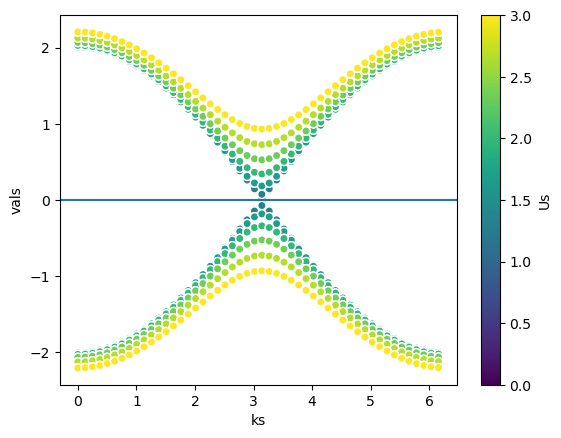

In [26]:
ds.vals.plot.scatter(x='ks', hue='Us')
plt.axhline(0)

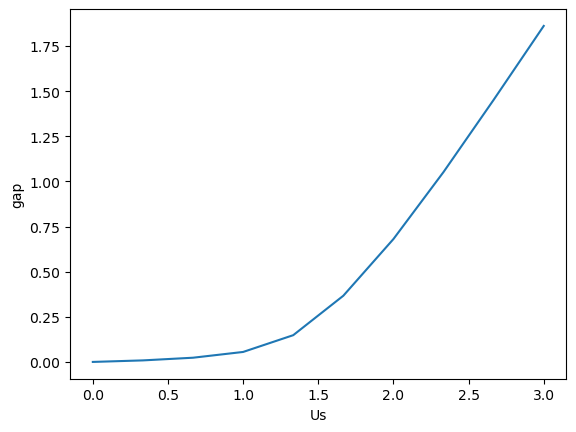

In [27]:
ds.gap.plot()

In [28]:
ds.to_netcdf('./data/1d_hubbard_example.nc')